### Необходимо провести анализ результатов A/B-тестирования в двух параллельных тестах по метрике линеаризированных лайков.

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR).

При этом метод сам по себе очень прост. Что это за метрика такая?

- Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 = 𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠) / 𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
- Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 = 𝑙𝑖𝑘𝑒𝑠 − 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
- После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). 

### <center> **Тест № 1**

* exp_group = 0 – Все по-старому
* exp_group = 3 – Рекомендации "постов, которые лайкали похожие на вас люди"

In [1]:
import pandas as pd
import numpy as np
import pandahouse
from scipy.stats import ttest_ind, mannwhitneyu, poisson

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# параметры подключения
# наверное, их стоило удалить?..
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

In [3]:
# для оптимизации заранее посчитаем стр для каждого пользователя
q = """
    SELECT
        user_id,
        exp_group,
        SUM(action='like') AS like,
        SUM(action='view') AS view,
        like / view AS ctr
    FROM simulator_20230720.feed_actions 
    WHERE toDate(time) >= '2023-06-30' and toDate(time) <= '2023-07-06'
        AND exp_group IN (0, 3)
    GROUP BY user_id, exp_group
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,like,view,ctr
0,115383,3,12,44,0.272727
1,123580,3,2,11,0.181818
2,4944,0,8,41,0.195122
3,4504,0,5,15,0.333333
4,121508,0,6,25,0.240000


In [4]:
# для наглядности заменим цифровые обозначения группы на словесные
df['exp_group'] = df['exp_group'].apply(lambda x: 'control' if x==0 else 'test')

# разделим датасет по группам
control = df[df['exp_group'] == 'control']
test = df[df['exp_group'] == 'test']

#### **Шаг 1. Визуальная оценка**

In [5]:
# проверим размерность 
print('Размер контрольной выборки:', control.shape[0])
print('Размер тестовой выборки:', test.shape[0])

Размер контрольной выборки: 9920
Размер тестовой выборки: 10002


Группы имеют примерно одинаковый размер.

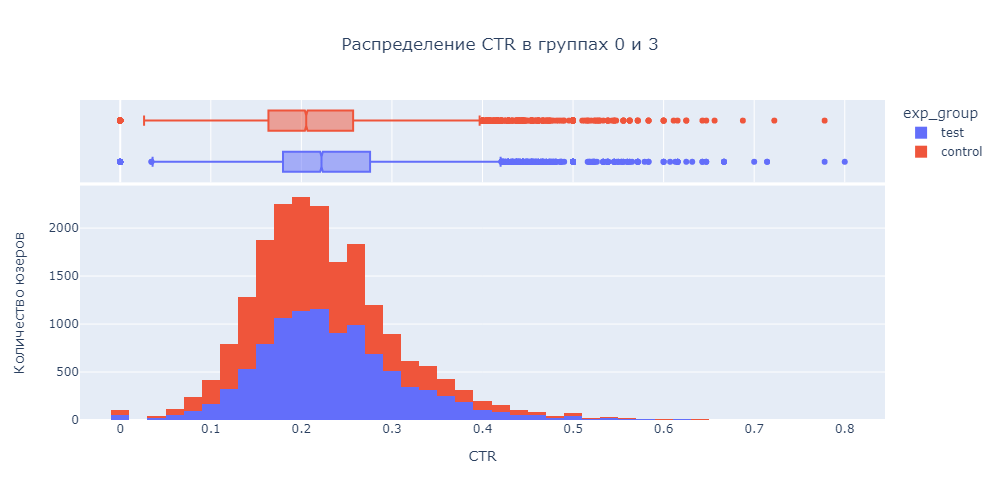

In [6]:
# построим гистограмму распределения ctr в разрезе групп
ctr_hist = px.histogram(
    data_frame=df,
    x='ctr',
    color='exp_group',
    marginal='box',
    width=1000,
    nbins=50,
    title='Распределение CTR в группах 0 и 3'
)

# добавим немного наглядности и выведем график
ctr_hist.update_layout(
    title=dict(x=.5, xanchor='center'),
    xaxis_title='CTR',
    yaxis_title='Количество юзеров')
ctr_hist.show('png')

Распределение в обеих группах похоже на нормальное, тестовая группа имеет более широкое распределение, большее медианное значение и т.д., однако однозначных выводов, к сожалению, сделать не получится (хоть и очень хочется).

#### **Шаг 2. t-тест**

In [7]:
# определяем гипотезы
Ho = 'Среднее значение CTR в обеих группах равны.'
Ha = 'Среднее значение CTR в контрольной и тестовой группе не равны.'

# укажем уровень значимости
alpha = 0.05

# посчитаем p-value
stat, p_value = ttest_ind(control['ctr'], test['ctr'], equal_var=False, alternative='two-sided')

print('p-value: ', p_value)

if p_value < alpha:
    print('Принимаем альтернативную гипотезу.', Ha)
else:
    print('Принимаем нулевую гипотезу.', Ho)

p-value:  6.216047483062228e-44
Принимаем альтернативную гипотезу. Среднее значение CTR в контрольной и тестовой группе не равны.


Ага, тогда стоит выяснить в какой группе среднее значение CTR выше. Проведем еще один t-тест, но уже с другой альтернативной гипотезой.

In [8]:
# определяем гипотезы
Ho = 'Среднее значение CTR в обеих группах равны.'
Ha = 'Среднее значение CTR в тестовой группе выше.'

# укажем уровень значимости
alpha = 0.05

# посчитаем p-value
stat, p_value = ttest_ind(control['ctr'], test['ctr'], equal_var=False, alternative='less')

print('p-value: ', p_value)

if p_value < alpha:
    print('Принимаем альтернативную гипотезу.', Ha)
else:
    print('Принимаем нулевую гипотезу.', Ho)

p-value:  3.108023741531114e-44
Принимаем альтернативную гипотезу. Среднее значение CTR в тестовой группе выше.


#### **Шаг 3. Линеаризация**

In [9]:
# считаем общий ctr в контроле
ctr_control = control['like'].sum() / control['view'].sum()

# считаем поюзерную метрику
control['linearized_like'] = control['like'] - ctr_control*control['view']
test['linearized_like'] = test['like'] - ctr_control*test['view']

C:\Users\volod\AppData\Local\Temp\ipykernel_28612\1972093291.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\volod\AppData\Local\Temp\ipykernel_28612\1972093291.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



После этого можно сравнить группы по линеарилизованной метрике.

In [10]:
# определяем гипотезы
Ho = 'Среднее значение CTR в обеих группах равны.'
Ha = 'Среднее значение CTR в тестовой группе выше.'

# укажем уровень значимости
alpha = 0.05

# посчитаем p-value
stat, p_value = ttest_ind(control['linearized_like'], test['linearized_like'], equal_var=False, alternative='less')

print('p-value: ', p_value)

if p_value < alpha:
    print('Принимаем альтернативную гипотезу.', Ha)
else:
    print('Принимаем нулевую гипотезу.', Ho)

p-value:  7.459068872663069e-59
Принимаем альтернативную гипотезу. Среднее значение CTR в тестовой группе выше.


#### **Шаг 4. Выводы**

Значение метрики CTR в тестовой группе 3, судя по визуальной оценке, оценке t-теста и оценке по метрике линеаризированных лайков, оказалось выше, чем в контрольной группе 0. В любом случае рекомендована проверка накопительных метрик для оценки адекватности длительности теста, прежде чем причинать решение о внедрении новой системы рекомендации ("рекомендация постов, которые лайкали похожие на вас люди") для всех пользователей.

Линеаризация на порядок снизила p-value. Конкретно для этой задачи ее проведение не требовалось, однако в спорных ситуациях с неоднозначными результатами стоит иметь в виду такой метод оценки.

### <center> **Тест № 2**

* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

Ранее мы уже проводили анализ этих групп, но продублируем информацию повторно для полности картины.

In [11]:
# для оптимизации заранее посчитаем стр для каждого пользователя
q = """
    SELECT
        user_id,
        exp_group,
        SUM(action='like') AS like,
        SUM(action='view') AS view,
        like / view AS ctr
    FROM simulator_20230720.feed_actions 
    WHERE toDate(time) >= '2023-06-30' and toDate(time) <= '2023-07-06'
        AND exp_group IN (1, 2)
    GROUP BY user_id, exp_group
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,like,view,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,18392,1,7,32,0.218750
4,26295,1,39,141,0.276596


In [12]:
# для визуализации изменим название групп
df['exp_group'] = df['exp_group'].apply(lambda x: 'control' if x==1 else 'test')

# разделим сразу датасет по группам
control = df[df['exp_group'] == 'control']
test = df[df['exp_group'] == 'test']

#### **Шаг 1. Визуальная оценка**

In [13]:
# проверим размерность 
print('Размер контрольной выборки:', control.shape[0])
print('Размер тестовой выборки:', test.shape[0])

Размер контрольной выборки: 10020
Размер тестовой выборки: 9877


Группы имеют примерно одинаковый размер.

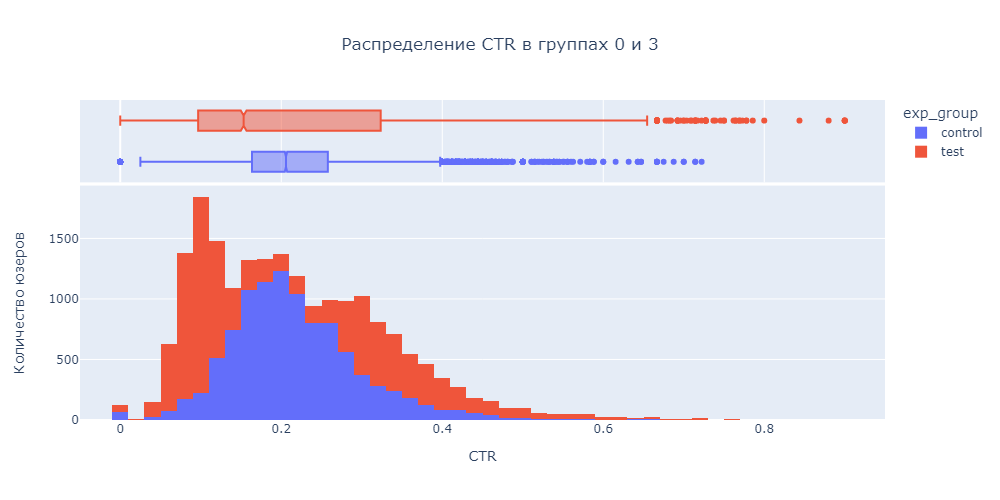

In [14]:
# построим гистограмму распределения ctr в разрезе групп
ctr_hist = px.histogram(
    data_frame=df,
    x='ctr',
    color='exp_group',
    marginal='box',
    width=1000,
    nbins=50,
    title='Распределение CTR в группах 0 и 3'
)

# добавим немного наглядности и выведем график
ctr_hist.update_layout(
    title=dict(x=.5, xanchor='center'),
    xaxis_title='CTR',
    yaxis_title='Количество юзеров')
ctr_hist.show('png')

Распределение в контрольной группе близко к нормальному, в то время как в тестовой группе нормальным его можно назвать уж совсем условно. Медианное (и, скорее всего, среднее тоже) значение заметно больше, чем в тестовой группе, а также имеет явно менее широкое распределение.  
Кажется результат уже сейчас довольно очевиден, тестовая группа явно превалирует у значений близких к нулю, имеет меньшую медиану. Но, стоит обратить внимание, что у количество пользователей с CTR > 0.3 в тестовой группе явно больше, что может быть связано с, например, полом, страной, типом ОС и тд.

#### **Шаг 2. t-тест**

In [15]:
# определяем гипотезы
Ho = 'Среднее значение CTR в обеих группах равны.'
Ha = 'Среднее значение CTR в контрольной и тестовой группе не равны.'

# укажем уровень значимости
alpha = 0.05

# посчитаем p-value
stat, p_value = ttest_ind(control['ctr'], test['ctr'], equal_var=False, alternative='two-sided')

print('p-value: ', p_value)

if p_value < alpha:
    print('Принимаем альтернативную гипотезу.', Ha)
else:
    print('Принимаем нулевую гипотезу.', Ho)

p-value:  0.685373331140751
Принимаем нулевую гипотезу. Среднее значение CTR в обеих группах равны.


#### **Шаг 3. Линеаризация**

In [16]:
# считаем общий ctr в контроле
ctr_control = control['like'].sum() / control['view'].sum()

# считаем поюзерную метрику
control['linearized_like'] = control['like'] - ctr_control*control['view']
test['linearized_like'] = test['like'] - ctr_control*test['view']

C:\Users\volod\AppData\Local\Temp\ipykernel_28612\1972093291.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\volod\AppData\Local\Temp\ipykernel_28612\1972093291.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
# определяем гипотезы
Ho = 'Среднее значение CTR в обеих группах равны.'
Ha = 'Среднее значение CTR в группах отличается.'

# укажем уровень значимости
alpha = 0.05

# посчитаем p-value
stat, p_value = ttest_ind(control['linearized_like'], test['linearized_like'], equal_var=False, alternative='two-sided')

print('p-value: ', p_value)

if p_value < alpha:
    print('Принимаем альтернативную гипотезу.', Ha)
else:
    print('Принимаем нулевую гипотезу.', Ho)

p-value:  2.9805064038668164e-09
Принимаем альтернативную гипотезу. Среднее значение CTR в группах отличается.


Интересно, результаты поменялись, причем p-value снизился многократно. Попробуем изменить гипотезу.

In [18]:
# определяем гипотезы
Ho = 'Среднее значение CTR в обеих группах равны.'
Ha = 'Среднее значение CTR в тестовой группе ниже, чем в контрольной.'

# укажем уровень значимости
alpha = 0.05

# посчитаем p-value
stat, p_value = ttest_ind(control['linearized_like'], test['linearized_like'], equal_var=False, alternative='greater')

print('p-value: ', p_value)

if p_value < alpha:
    print('Принимаем альтернативную гипотезу.', Ha)
else:
    print('Принимаем нулевую гипотезу.', Ho)

p-value:  1.4902532019334082e-09
Принимаем альтернативную гипотезу. Среднее значение CTR в тестовой группе ниже, чем в контрольной.


#### **Шаг 4. Выводы**

Применение линеаризации вновь привело к значительному снижению p-value, однако вновь эту информацию сложно назвать полезной, поскольку даже до применение данного метода не было смысла в введении новой системы рекомендаций ("рекомендации похожих на лайкнутые постов""), раз CTR теста оказался не выше CTR контроля.  

Но в случае обратной ситуации, если бы линеаризация давала бы результат в пользу тестовой, а не контрольной группы, этот метод мог бы сильно повлиять на наши дальнейшие действия.

Однозначно, введение для всех пользователей системы рекомендаций с учетом известных данных не имеет смысла.

### <center> **Общие выводы**

**1.** По результатам двух параллельных A/B-тестов стоит рассмотреть возможность введения новой системы рекомендаций ("рекомендации постов, которые лайкали похожие на вас люди"), испытанной на группе 3, поскольку мы видим однозначное повышение по метрике CTR.  

**2.** Стоит учесть во внимание не бесполезность и другой системы рекомендаций, испытанной на группе 2, поскольку у рядя пользователей зафиксировано повышение CTR. Это означает, что эти пользователи могут быть объединены неким свойством/критерием, который на данный момент не был выявлен. Кроме того, возможно, стоит рассмотреть вариант увеличения срока проведения тестирования для получения более объективных результатов.  

**3.** Метод линеаризации значительно повышает чувствительность метрики, снижает p-value, что в случае спорных и неоднозначных результатов может заметно помочь в принятии решения. 